In [78]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler as ss, OrdinalEncoder as oe, LabelEncoder as le
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split as tts, cross_validate, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, precision_score
import optuna as op
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

Domyślne parametry, wyniki czasem stuprocentowe, a czasem blisko stuprocentowe, zdecydowanie przeuczenie, aczkolwiek też zauważam mało przypadków ogólnie, możliwe że w tym przypadku mała próbka pozwala na małą szansę na błąd

In [57]:
data = pd.read_csv("stars.csv")
data.dropna(inplace=True)
data['Star color']=oe().fit_transform(data[['Star color']])
data['Spectral Class']=oe().fit_transform(data[['Spectral Class']])

X=np.c_[data.to_numpy()[:,0:4],data.to_numpy()[:,5:7]]
X=ss().fit_transform(X)
y=data.to_numpy()[:,4]
X_train, X_test, y_train, y_test = tts(X, y, train_size=0.6, random_state=86)

model = SVC()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96        13
         1.0       1.00      0.93      0.97        15
         2.0       1.00      1.00      1.00        17
         3.0       1.00      0.94      0.97        17
         4.0       0.94      1.00      0.97        17
         5.0       1.00      1.00      1.00        17

    accuracy                           0.98        96
   macro avg       0.98      0.98      0.98        96
weighted avg       0.98      0.98      0.98        96

[[13  0  0  0  0  0]
 [ 1 14  0  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  0 16  1  0]
 [ 0  0  0  0 17  0]
 [ 0  0  0  0  0 17]]


Wydaje mi się, iż do optuny powinienem wykorzystać precyzję, ponieważ nie powinien interesować mnie sotsunek do wszystkich przypadków. Mamy wiele klas i liczy się tylko to, jak wiele przypisanych obiektów do danej klasy jest przypisanych poprawnie.

In [74]:
# Definicja metryki scoringowej
scoring = {'Precision': make_scorer(precision_score, average='weighted', zero_division = 1)}

# Funkcja celu
def objective(trial, model, get_space, X, y):
    model_space = get_space(trial)
    mdl = model(**model_space)
    scores = cross_validate(
        mdl, X, y,
        scoring=scoring,
        cv=StratifiedKFold(n_splits=5),
        return_train_score=True
    )
    return np.mean(scores['test_Precision'])

# Przestrzeń hiperparametrów
def get_space(trial):
    space = {
        "C": trial.suggest_float("C", 0, 2),
        "max_iter": trial.suggest_int("max_iter", 100, 1000),
        "kernel": trial.suggest_categorical(
            "kernel", ["linear", "poly", "rbf", "sigmoid",]
        ),
        "degree": trial.suggest_int("degree", 1, 5),
        "decision_function_shape": trial.suggest_categorical("decision_function_shape", ["ovo", "ovr"]),
        "gamma": trial.suggest_categorical("gamma", ['scale', 'auto'])
    }
    return space

# Liczba prób optymalizacji
trials = 500
model = SVC

# Optymalizacja
study = op.create_study(direction='maximize')
study.optimize(
    lambda x: objective(x, model, get_space, X_train, y_train),
    n_trials=trials
)

clear_output()

# Wyświetlenie najlepszych wartości hiperparametrów
print('params:', study.best_params)

# Trening modelu z optymalnymi hiperparametrami
svm = model(**study.best_params)
svm.fit(X_train, y_train)

# Ewaluacja modelu
preds = svm.predict(X_test)
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))


params: {'C': 1.9906821517115725, 'max_iter': 924, 'kernel': 'linear', 'degree': 2, 'decision_function_shape': 'ovr', 'gamma': 'auto'}
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96        13
         1.0       1.00      0.93      0.97        15
         2.0       1.00      1.00      1.00        17
         3.0       1.00      1.00      1.00        17
         4.0       1.00      1.00      1.00        17
         5.0       1.00      1.00      1.00        17

    accuracy                           0.99        96
   macro avg       0.99      0.99      0.99        96
weighted avg       0.99      0.99      0.99        96

[[13  0  0  0  0  0]
 [ 1 14  0  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  0 17  0  0]
 [ 0  0  0  0 17  0]
 [ 0  0  0  0  0 17]]


ValueError: X has 2 features, but SVC is expecting 6 features as input.

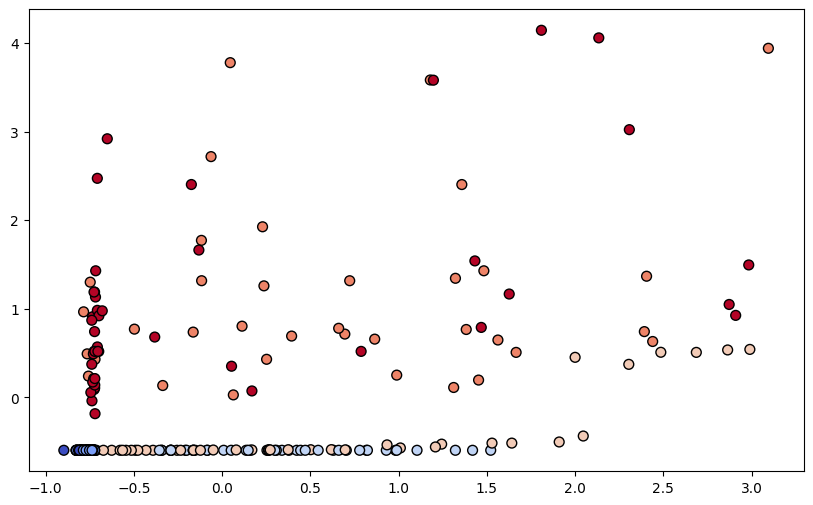

In [ ]:
data = pd.read_csv("stars.csv")
data.dropna(inplace=True)
data['Star color']=oe().fit_transform(data[['Star color']])
data['Spectral Class']=oe().fit_transform(data[['Spectral Class']])

X=np.c_[data.to_numpy()[:,0:4],data.to_numpy()[:,5:7]]
X=ss().fit_transform(X)
X=
y=data.to_numpy()[:,4]
X_train, X_test, y_train, y_test = tts(X, y, train_size=0.6, random_state=86)

model = SVC()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Wyświetlanie wyników na wykresie
plt.figure(figsize=(10, 6))

# Rysowanie punktów danych
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=50, edgecolors='k')

# Rysowanie granicy decyzyjnej
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 30), np.linspace(ylim[0], ylim[1], 30))
Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

ax.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap='coolwarm', alpha=0.5)
ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors='k')

plt.title('Wyniki SVC na wykresie')
plt.xlabel('Cecha 1')
plt.ylabel('Cecha 2')
plt.show()

Przed i po niewiele się zmienia, nadal wyniki są równe 1 bliskie 1